In [1]:
!pip install faiss-cpu
!pip install catboost


[notice] A new release of pip available: 22.3 -> 23.2.1
[notice] To update, run: C:\Users\alexm\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3 -> 23.2.1
[notice] To update, run: C:\Users\alexm\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import faiss

from catboost import CatBoost, CatBoostClassifier
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

In [3]:
# Read the CSV file
df_base = pd.read_csv('datasets\\base.csv', index_col=0)
df_train = pd.read_csv('datasets\\train.csv', index_col=0)
df_validation = pd.read_csv('datasets\\validation.csv', index_col=0)
df_validation_answer = pd.read_csv('datasets\\validation_answer.csv', index_col=0)

In [4]:
def describe_dataframe(dataframe):
    display(dataframe.head(10))
    display(dataframe.info())
    display(dataframe.describe(percentiles=[.5]).T)
    print(f"Количество дублированных строк: {dataframe.duplicated().sum()}")

In [5]:
describe_dataframe(df_base)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.666340,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.202110,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.566180,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.202890,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.766320,-2.505783,65.315285,135.051590,-1074.464888,0.319401
5-base,-50.510876,6.740296,-81.952030,-142.06926,129.064470,-121.037380,-365.401703,79.924280,124.752650,102.136750,...,-103.298900,28.675972,-208.37845,-78.293455,66.580765,70.894360,30.805370,134.891560,-913.638206,-30.293541
6-base,-132.349780,12.640369,-80.635895,-137.11795,89.345490,-94.853520,-462.933977,91.356030,126.557274,147.394900,...,-55.650047,29.008305,-138.24612,156.300510,67.054200,-25.324776,85.734146,138.853520,-1070.516278,-2.041809
7-base,-80.561770,9.547482,-44.353603,-141.60060,133.501530,-72.643170,-484.413795,-6.601168,122.312370,103.568220,...,-55.613580,55.202328,-179.15207,48.050861,66.357260,26.573547,115.890150,110.674900,-1074.464888,-69.883660
8-base,-110.159720,5.319833,8.020306,-172.44500,79.661644,-100.075910,-2.583556,28.758438,122.134224,174.900270,...,-54.116820,36.942806,-133.81061,-23.802479,69.412280,-51.071934,91.097830,108.008660,-426.686160,-12.405426


<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 38  38      float64
 39  39      float64


None

,count,mean,std,min,50%,max
0,2918139.0,-86.229474,24.891320,-199.468700,-86.231500,21.515549
1,2918139.0,8.080077,4.953387,-13.914608,8.038950,29.937210
2,2918139.0,-44.580804,38.631660,-240.073400,-43.816605,160.937230
3,2918139.0,-146.634991,19.844805,-232.667140,-146.776810,-51.374780
4,2918139.0,111.316628,46.348090,-105.582960,111.873000,319.664500
...,...,...,...,...,...,...
67,2918139.0,23.544896,55.342236,-233.138170,23.416494,314.898770
68,2918139.0,74.959301,61.345005,-203.601620,74.929970,339.573850
69,2918139.0,115.566716,21.175183,15.724480,116.024445,214.706340
70,2918139.0,-799.339026,385.413088,-1297.931468,-1074.464888,98.770811


Количество дублированных строк: 0


In [6]:
describe_dataframe(df_train)

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base
5-query,-92.844185,2.975510,-61.760483,-171.67546,144.798370,-58.685143,104.112909,75.844580,118.336230,81.981125,...,12.807585,-137.96362,86.282088,64.678535,64.527600,64.664440,126.914600,-800.428664,-30.197390,2381316-base
6-query,-127.996580,9.672705,-37.678320,-141.41304,119.940926,-76.850460,-15.455417,75.031220,128.762990,266.939580,...,65.676480,-145.51813,139.211140,69.942120,21.280258,76.636410,85.143050,-44.371931,-15.524637,773187-base
7-query,-59.506752,7.959120,21.068153,-142.99788,128.157990,-92.496300,-143.453758,10.710561,131.086790,71.491560,...,49.263610,-203.78833,-101.989379,67.291770,44.437595,45.183838,150.288530,-1074.464888,-66.052086,2488580-base
8-query,-111.359276,6.414694,-88.023330,-131.79814,157.491360,-83.075620,-759.626065,49.599327,120.683470,87.519910,...,45.634857,-136.84851,117.466574,68.664635,-19.192120,54.241932,92.495636,11.012047,-61.062813,24129-base


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21  21  

None

,count,mean,std,min,50%,max
0,100000.0,-85.328679,25.803845,-186.280270,-85.273695,14.585236
1,100000.0,7.664345,4.955651,-11.560507,7.652854,28.917845
2,100000.0,-43.667046,39.111064,-224.896060,-42.830246,128.108460
3,100000.0,-146.118630,20.434841,-223.307220,-146.067445,-60.751625
4,100000.0,111.770592,47.700958,-93.272020,112.260100,301.363600
...,...,...,...,...,...,...
67,100000.0,23.029277,55.470761,-203.746380,23.441363,266.493320
68,100000.0,73.412076,62.203132,-181.973820,72.880192,319.867520
69,100000.0,115.189717,21.582238,22.598862,115.236635,201.761260
70,100000.0,-709.761548,405.961084,-1297.871984,-808.801696,98.768233


Количество дублированных строк: 0


In [7]:
describe_dataframe(df_validation)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.745940,-81.279594,-461.003172,139.815720,112.880980,75.215750,...,-75.513020,52.830902,-143.43945,59.051935,69.28224,61.927513,111.592530,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.449910,-90.520130,-759.626065,63.995087,127.117905,53.128998,...,-79.441830,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.077160,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.446160,-62.377740,-759.626065,87.477554,131.270110,168.920320,...,-134.795410,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.636410,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.697080,-133.729720,58.576403,-19.046660,115.042404,75.206730,...,-77.236110,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.183960,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.453920,-28.291668,33.931936,34.411217,128.903980,102.086914,...,-123.770250,45.635944,-134.25893,13.735359,70.61763,15.332115,154.568120,101.700640,-1171.892332,-125.307890
100005-query,-89.745360,6.317698,-80.744650,-114.53197,153.960340,-74.897130,-208.928691,-32.214005,115.582855,61.603172,...,-64.934890,37.824436,-153.04173,-131.257912,68.26281,56.239280,120.646900,76.342550,-1156.992950,-72.146390
100006-query,-64.514260,7.711647,-28.726236,-220.05089,186.177460,-42.254353,96.324664,-30.496332,109.519530,217.348480,...,-31.122826,11.672802,-112.34755,183.939297,67.22618,65.571060,-6.655426,95.882780,-1176.878727,-37.918420
100007-query,-119.026850,7.536469,-62.973827,-142.94609,150.376110,-92.343550,-530.124724,24.280703,124.623260,119.622160,...,-121.699980,49.379295,-211.29207,37.299723,68.56667,21.038134,37.364270,116.667170,-1129.242913,-87.194520
100008-query,-100.618990,10.874402,-59.983580,-147.85175,86.138500,-90.452470,-638.720433,111.696850,120.869210,125.254510,...,-68.627860,76.054110,-176.23720,173.788344,68.73241,222.442140,-38.008790,111.531290,-1231.711711,-85.407120


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21

None

,count,mean,std,min,50%,max
0,100000.0,-85.302233,25.777321,-190.353330,-85.296745,14.427986
1,100000.0,7.669724,4.956990,-11.109877,7.657888,27.409784
2,100000.0,-43.842474,39.138775,-217.538420,-43.230835,134.859800
3,100000.0,-146.119797,20.495541,-220.050890,-146.080365,-57.381890
4,100000.0,111.635071,47.751576,-81.198990,111.959330,302.065370
...,...,...,...,...,...,...
67,100000.0,23.250779,55.403862,-210.672800,23.508739,251.288590
68,100000.0,73.114446,62.056224,-175.921780,72.152398,305.937530
69,100000.0,115.196935,21.493081,25.271042,115.280990,201.599980
70,100000.0,-709.457021,405.665764,-1297.923999,-807.029697,98.737079


Количество дублированных строк: 0


In [8]:
describe_dataframe(df_validation_answer)

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base
100005-query,1905037-base
100006-query,306584-base
100007-query,1533713-base
100008-query,2796017-base


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Expected  100000 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB


None

,count,unique,top,freq
Expected,100000,91502,210304-base,7


Количество дублированных строк: 8498


In [9]:
scaler = StandardScaler()
scaler.fit(df_base)

StandardScaler()

In [10]:
df_base_scaled = pd.DataFrame(scaler.transform(df_base), index=df_base.index)

In [11]:
dims = df_base.shape[1]
n_cells = 1
df_base_scaled_values = np.ascontiguousarray(df_base_scaled).astype('float32')
df_base_scaled_values

array([[-1.1592162 ,  0.6203504 , -0.51372266, ..., -0.0140507 ,
         1.7814198 , -0.3123287 ],
       [ 2.0757148 ,  1.0604233 , -0.652491  , ...,  0.05984761,
         1.8537259 , -0.2810519 ],
       [ 1.2854173 , -0.34334213,  0.39787757, ...,  0.04852086,
        -0.7138468 ,  0.36562327],
       ...,
       [-0.43377605, -2.064035  , -0.6909693 , ...,  0.65973157,
        -0.7138468 ,  1.2577736 ],
       [-0.02446461,  0.16793925,  0.25220424, ...,  0.43807346,
        -0.7138468 , -0.19157949],
       [-0.6321802 ,  0.96488   , -0.17634064, ..., -1.0735649 ,
        -0.7121896 ,  1.4986584 ]], dtype=float32)

In [12]:
# Инициализация индексатора FAISS
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [13]:
idx_l2.train(df_base_scaled_values)

idx_l2.add(df_base_scaled_values)

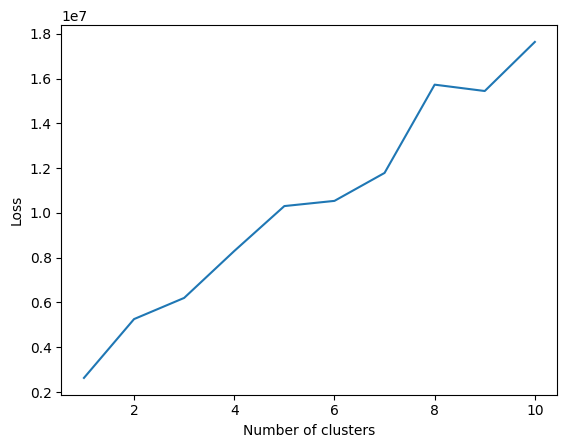

In [14]:
# Расчет функции потерь для разного количества кластеров
losses = []
for num_clusters in range(1, 11):
    kmeans = faiss.Kmeans(dims, num_clusters)
    kmeans.train(df_base_scaled_values)
    _, dist = idx_l2.search(kmeans.centroids, 1)
    loss = np.sum(dist)
    losses.append(loss)

# Построение графика значения функции потерь
plt.plot(range(1, 11), losses)
plt.xlabel('Number of clusters')
plt.ylabel('Loss')
plt.show()

In [15]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

In [16]:
targets = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)

In [17]:
df_train_scaled = pd.DataFrame(scaler.transform(df_train), index=df_train.index)
train_values = np.ascontiguousarray(df_train_scaled).astype('float32')
train_values

array([[ 1.2995186 ,  1.9968884 ,  0.06377414, ...,  0.9065748 ,
         0.99526674,  0.5229633 ],
       [-0.06214603, -0.25715932,  0.32424858, ...,  0.70945865,
        -0.61168975, -0.08349097],
       [ 1.4563276 , -0.85569566, -1.851792  , ...,  0.30057615,
        -0.7138468 ,  0.6046772 ],
       ...,
       [ 1.2968874 , -0.67694914,  0.3960963 , ..., -0.18653943,
         0.219093  ,  1.0424612 ],
       [ 0.3578639 ,  0.41189885, -0.50254726, ..., -0.22969231,
        -0.7138468 , -0.7594065 ],
       [-0.11325181,  0.5770834 , -0.22327293, ..., -0.70412654,
         1.9609631 , -0.77516645]], dtype=float32)

In [18]:
%%time
vecs, idx = idx_l2.search(train_values, 20)

CPU times: total: 9h 22min 36s
Wall time: 38min 19s


In [19]:
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

72.99


In [20]:
%%time
df_distances = pd.DataFrame()

# для каждого запроса из обучающего набора данных
for i in range(df_train.shape[0]):
    # берем расстояния от запроса до рекомендаций FAISS от первых 10 элементов.
    temp_df = pd.concat([pd.DataFrame(idx[i][:10]), pd.DataFrame(vecs[i][:10])], axis=1)

    temp_df.columns = ['idx', 'distance']

    # индекс вектора-запроса для получения его координат
    temp_df['query_idx'] = f'{i}-query'

    # индекс вектора рекомендаций экспертов
    temp_df['target_idx'] = targets[i]

    df_distances = pd.concat([df_distances, temp_df], ignore_index=True)

CPU times: total: 13min 36s
Wall time: 13min 36s


In [34]:
df_distances.tail()

,idx,distance,query_idx,target_idx,base_idx,target,0_x,1_x,2_x,3_x,...,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y
999988,1430547,5.967613,99998-query,9252-base,1861685-base,0,0.357864,0.411899,-0.502547,1.552935,...,-3.591553,1.338642,-0.507661,-1.185903,-1.138544,-1.053340,-0.247918,-0.135820,-0.713847,-0.505661
999990,1958647,1.949338,99999-query,2769109-base,2769109-base,1,-0.113252,0.577083,-0.223273,0.123277,...,-0.076096,-0.973159,0.485453,-0.940010,-0.497467,0.398658,0.897109,-0.704312,1.960963,-0.775120
999992,1831967,45.285156,99999-query,2769109-base,2539368-base,0,-0.113252,0.577083,-0.223273,0.123277,...,-0.152696,-0.822039,0.676110,-0.900116,0.084016,0.936706,0.872203,1.067114,2.102800,-0.747574
999996,1138466,50.704590,99999-query,2769109-base,1412044-base,0,-0.113252,0.577083,-0.223273,0.123277,...,-0.372890,-1.902764,-0.010069,0.963151,0.875052,0.511212,0.674809,-1.445297,0.869343,-0.565825
999999,48897,53.081379,99999-query,2769109-base,49440-base,0,-0.113252,0.577083,-0.223273,0.123277,...,-0.417008,0.430435,0.103303,-0.144794,0.068380,-0.561988,0.732958,1.572562,1.604687,-0.528468


In [22]:
# функция для получения индекса рекомендаций в базовом наборе товаров по индексу FAISS
def get_base_idx(row):
    return base_index[row['idx']]

In [23]:
# по внутреннему индексу FAISS восстанавливаем индекс рекомендованного товара в базовом наборе
df_distances['base_idx'] = df_distances.apply(get_base_idx, axis=1)
df_distances.head()

,idx,distance,query_idx,target_idx,base_idx
0,598613,19.299540,0-query,675816-base,675816-base
1,755584,19.467600,0-query,675816-base,877519-base
2,336969,20.747215,0-query,675816-base,361564-base
3,1934845,23.199968,0-query,675816-base,2725256-base
4,13374,23.545162,0-query,675816-base,13406-base


In [24]:
df_distances['target'] = df_distances['target_idx'] == df_distances['base_idx']
df_distances['target'] = df_distances['target'].astype('int')
df_distances.head()

,idx,distance,query_idx,target_idx,base_idx,target
0,598613,19.299540,0-query,675816-base,675816-base,1
1,755584,19.467600,0-query,675816-base,877519-base,0
2,336969,20.747215,0-query,675816-base,361564-base,0
3,1934845,23.199968,0-query,675816-base,2725256-base,0
4,13374,23.545162,0-query,675816-base,13406-base,0


In [25]:
# добавляем координаты векторов-запросов
df_distances = df_distances.merge(df_train_scaled, how='inner', left_on='query_idx', right_index=True)
df_distances.head()

,idx,distance,query_idx,target_idx,base_idx,target,0,1,2,3,...,62,63,64,65,66,67,68,69,70,71
0,598613,19.299540,0-query,675816-base,675816-base,1,1.299519,1.996888,0.063774,-1.879671,...,-0.866975,1.274319,-0.02441,-1.173481,-1.035388,0.197184,-0.200786,0.906575,0.995267,0.522963
1,755584,19.467600,0-query,675816-base,877519-base,0,1.299519,1.996888,0.063774,-1.879671,...,-0.866975,1.274319,-0.02441,-1.173481,-1.035388,0.197184,-0.200786,0.906575,0.995267,0.522963
2,336969,20.747215,0-query,675816-base,361564-base,0,1.299519,1.996888,0.063774,-1.879671,...,-0.866975,1.274319,-0.02441,-1.173481,-1.035388,0.197184,-0.200786,0.906575,0.995267,0.522963
3,1934845,23.199968,0-query,675816-base,2725256-base,0,1.299519,1.996888,0.063774,-1.879671,...,-0.866975,1.274319,-0.02441,-1.173481,-1.035388,0.197184,-0.200786,0.906575,0.995267,0.522963
4,13374,23.545162,0-query,675816-base,13406-base,0,1.299519,1.996888,0.063774,-1.879671,...,-0.866975,1.274319,-0.02441,-1.173481,-1.035388,0.197184,-0.200786,0.906575,0.995267,0.522963


In [26]:
# добавляем координаты векторов-рекомендаций FAISS
df_distances = df_distances.merge(df_base_scaled, how='inner', left_on='base_idx', right_index=True)
df_distances.head()

,idx,distance,query_idx,target_idx,base_idx,target,0_x,1_x,2_x,3_x,...,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y
0,598613,19.299540,0-query,675816-base,675816-base,1,1.299519,1.996888,0.063774,-1.879671,...,-0.927103,1.627806,0.072924,0.427460,-0.496641,0.394758,-0.568302,0.066837,0.995267,0.708902
1,755584,19.467600,0-query,675816-base,877519-base,0,1.299519,1.996888,0.063774,-1.879671,...,-0.676032,1.615281,-0.247046,-0.404396,-1.148503,0.412697,-0.375744,0.728224,0.544932,0.270560
9011,755584,40.878693,901-query,161242-base,877519-base,0,1.916994,1.153344,-0.199909,-1.319427,...,-0.676032,1.615281,-0.247046,-0.404396,-1.148503,0.412697,-0.375744,0.728224,0.544932,0.270560
167470,755584,18.697302,16747-query,279936-base,877519-base,0,0.429194,1.314741,-0.513722,-1.220226,...,-0.676032,1.615281,-0.247046,-0.404396,-1.148503,0.412697,-0.375744,0.728224,0.544932,0.270560
289074,755584,30.626114,28907-query,674092-base,877519-base,0,0.524340,2.303420,0.334275,-1.683806,...,-0.676032,1.615281,-0.247046,-0.404396,-1.148503,0.412697,-0.375744,0.728224,0.544932,0.270560


In [27]:
# характеристики для обучения
df_features = df_distances.drop(['idx', 'query_idx', 'target_idx', 'base_idx', 'target'], axis=1)
df_features

,distance,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,...,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y
0,19.299540,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.165148,0.279598,-2.296794,...,-0.927103,1.627806,0.072924,0.427460,-0.496641,0.394758,-0.568302,0.066837,0.995267,0.708902
1,19.467600,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.165148,0.279598,-2.296794,...,-0.676032,1.615281,-0.247046,-0.404396,-1.148503,0.412697,-0.375744,0.728224,0.544932,0.270560
9011,40.878693,1.916994,1.153344,-0.199909,-1.319427,-0.193553,-0.269549,-1.287975,0.345101,-0.892164,...,-0.676032,1.615281,-0.247046,-0.404396,-1.148503,0.412697,-0.375744,0.728224,0.544932,0.270560
167470,18.697302,0.429194,1.314741,-0.513722,-1.220226,1.779113,0.047929,1.152288,0.592973,-2.010040,...,-0.676032,1.615281,-0.247046,-0.404396,-1.148503,0.412697,-0.375744,0.728224,0.544932,0.270560
289074,30.626114,0.524340,2.303420,0.334275,-1.683806,1.698728,-0.685473,-1.404976,-0.105586,-1.860783,...,-0.676032,1.615281,-0.247046,-0.404396,-1.148503,0.412697,-0.375744,0.728224,0.544932,0.270560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999988,5.967613,0.357864,0.411899,-0.502547,1.552935,0.622546,-0.811189,-1.047148,1.632550,-0.897114,...,-3.591553,1.338642,-0.507661,-1.185903,-1.138544,-1.053340,-0.247918,-0.135820,-0.713847,-0.505661
999990,1.949338,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,1.149390,0.885642,-0.902251,...,-0.076096,-0.973159,0.485453,-0.940010,-0.497467,0.398658,0.897109,-0.704312,1.960963,-0.775120
999992,45.285156,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,1.149390,0.885642,-0.902251,...,-0.152696,-0.822039,0.676110,-0.900116,0.084016,0.936706,0.872203,1.067114,2.102800,-0.747574
999996,50.704590,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,1.149390,0.885642,-0.902251,...,-0.372890,-1.902764,-0.010069,0.963151,0.875052,0.511212,0.674809,-1.445297,0.869343,-0.565825


In [28]:
# целевой признак
df_target = df_distances['target']
df_target.value_counts() / df_target.shape[0]

0    0.930211
1    0.069789
Name: target, dtype: float64

In [29]:
df_pipeline = make_pipeline(
    SMOTE(random_state=32123),
    CatBoostClassifier(auto_class_weights = 'Balanced', verbose=50)
)

In [31]:
# temp1 = SMOTE(random_state=32123).fit_resample(df_features, df_target)['target']

(          distance       0_x       1_x       2_x       3_x       4_x  \
 0        19.299540  1.299519  1.996888  0.063774 -1.879671  1.644100   
 1        19.467600  1.299519  1.996888  0.063774 -1.879671  1.644100   
 2        40.878693  1.916994  1.153344 -0.199909 -1.319427 -0.193553   
 3        18.697302  0.429194  1.314741 -0.513722 -1.220226  1.779113   
 4        30.626114  0.524340  2.303420  0.334275 -1.683806  1.698728   
 ...            ...       ...       ...       ...       ...       ...   
 1860417   7.030002  1.862487  0.027892 -0.840501  1.034538 -1.168015   
 1860418  19.709759 -1.187909 -0.202086 -1.336130 -0.937215 -0.830566   
 1860419   3.866744 -0.579108 -1.117360 -0.409083  0.433854 -1.245978   
 1860420  23.582809 -0.432942  0.515675  0.311730  1.574649 -0.027549   
 1860421  41.477505  1.777069  0.619194 -0.026361 -1.313416  1.977830   
 
               5_x       6_x       7_x       8_x  ...      62_y      63_y  \
 0       -0.537626  0.165148  0.279598 -2.296

In [30]:
%%time
df_pipeline.fit(df_features, df_target)

Learning rate set to 0.256483
0:	learn: 0.5704084	total: 489ms	remaining: 8m 8s
50:	learn: 0.2311235	total: 14.8s	remaining: 4m 34s
100:	learn: 0.1903140	total: 28.2s	remaining: 4m 11s
150:	learn: 0.1667686	total: 41.9s	remaining: 3m 55s
200:	learn: 0.1516256	total: 55.3s	remaining: 3m 39s
250:	learn: 0.1381000	total: 1m 8s	remaining: 3m 25s
300:	learn: 0.1291825	total: 1m 22s	remaining: 3m 11s
350:	learn: 0.1226270	total: 1m 35s	remaining: 2m 56s
400:	learn: 0.1153106	total: 1m 49s	remaining: 2m 43s
450:	learn: 0.1091781	total: 2m 3s	remaining: 2m 30s
500:	learn: 0.1041827	total: 2m 17s	remaining: 2m 17s
550:	learn: 0.0995217	total: 2m 31s	remaining: 2m 3s
600:	learn: 0.0956310	total: 2m 45s	remaining: 1m 49s
650:	learn: 0.0906413	total: 2m 59s	remaining: 1m 36s
700:	learn: 0.0873879	total: 3m 13s	remaining: 1m 22s
750:	learn: 0.0839171	total: 3m 27s	remaining: 1m 8s
800:	learn: 0.0812089	total: 3m 41s	remaining: 54.9s
850:	learn: 0.0775747	total: 3m 56s	remaining: 41.3s
900:	learn: 0

Pipeline(steps=[('smote', SMOTE(random_state=32123)),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x000001F5C3D2FFD0>)])

In [35]:
df_validation_scaled = pd.DataFrame(scaler.transform(df_validation), index=df_validation.index)

In [32]:
# проводим поиск с помощью FAISS
val_vecs, val_idx = idx_l2.search(np.ascontiguousarray(df_validation_scaled.values).astype('float32'), 20)

In [36]:
# accuracy@20
acc = 0
for target, el in zip(df_validation_answer.values.tolist(), val_idx.tolist()):
    acc += int(target[0] in [base_index[r] for r in el])

print(100 * acc / len(idx))

72.976


In [37]:
df_distances_cb = pd.DataFrame()

for i in range(df_validation.shape[0]):
    df = pd.concat([pd.DataFrame(val_idx[i][:10]), pd.DataFrame(val_vecs[i][:10])], axis=1)

    df.columns = ['idx', 'distance']
    df['query_idx'] = f'{100000 + i}-query'
    df['target_idx'] = df_validation_answer.values[i][0]
    df_distances_cb = pd.concat([df_distances_cb, df], ignore_index=True)
df_distances_cb.tail()

,idx,distance,query_idx,target_idx
999995,1811737,36.874481,199999-query,336472-base
999996,58213,38.584469,199999-query,336472-base
999997,1096879,38.665546,199999-query,336472-base
999998,83340,39.445202,199999-query,336472-base
999999,315821,40.044304,199999-query,336472-base


In [38]:
# по внутреннему индексу FAISS восстанавливаем индекс рекомендованного товара в базовом наборе
df_distances_cb['base_idx'] = df_distances_cb.apply(get_base_idx, axis=1)
df_distances_cb.head()

,idx,distance,query_idx,target_idx,base_idx
0,2192372,8.076221,100000-query,2676668-base,3209652-base
1,2177660,10.031794,100000-query,2676668-base,3181043-base
2,342838,13.769163,100000-query,2676668-base,368296-base
3,574649,14.486226,100000-query,2676668-base,645855-base
4,1954150,18.285746,100000-query,2676668-base,2760762-base


In [39]:
# добавляем координаты векторов-запросов
df_distances_cb = df_distances_cb.merge(df_validation_scaled, how='inner', left_on='query_idx', right_index=True)
df_distances_cb.head()

,idx,distance,query_idx,target_idx,base_idx,0,1,2,3,4,...,62,63,64,65,66,67,68,69,70,71
0,2192372,8.076221,100000-query,2676668-base,3209652-base,1.15931,-0.904901,0.811955,1.043508,-0.012313,...,0.115241,0.676228,0.275453,0.453766,0.817488,0.69355,0.597167,-0.020121,-0.777845,-1.659674
1,2177660,10.031794,100000-query,2676668-base,3181043-base,1.15931,-0.904901,0.811955,1.043508,-0.012313,...,0.115241,0.676228,0.275453,0.453766,0.817488,0.69355,0.597167,-0.020121,-0.777845,-1.659674
2,342838,13.769163,100000-query,2676668-base,368296-base,1.15931,-0.904901,0.811955,1.043508,-0.012313,...,0.115241,0.676228,0.275453,0.453766,0.817488,0.69355,0.597167,-0.020121,-0.777845,-1.659674
3,574649,14.486226,100000-query,2676668-base,645855-base,1.15931,-0.904901,0.811955,1.043508,-0.012313,...,0.115241,0.676228,0.275453,0.453766,0.817488,0.69355,0.597167,-0.020121,-0.777845,-1.659674
4,1954150,18.285746,100000-query,2676668-base,2760762-base,1.15931,-0.904901,0.811955,1.043508,-0.012313,...,0.115241,0.676228,0.275453,0.453766,0.817488,0.69355,0.597167,-0.020121,-0.777845,-1.659674


In [40]:
# добавляем координаты векторов-рекомендаций FAISS
df_distances_cb = df_distances_cb.merge(df_base_scaled, how='inner', left_on='base_idx', right_index=True)
df_distances_cb.head()

,idx,distance,query_idx,target_idx,base_idx,0_x,1_x,2_x,3_x,4_x,...,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y
0,2192372,8.076221,100000-query,2676668-base,3209652-base,1.159310,-0.904901,0.811955,1.043508,-0.012313,...,0.457506,0.948873,0.570802,1.213205,0.909867,0.897679,0.018913,0.430446,-0.713847,-1.182590
967706,2192372,19.433861,196770-query,976413-base,3209652-base,0.627229,-0.452532,1.104286,0.968336,0.144250,...,0.457506,0.948873,0.570802,1.213205,0.909867,0.897679,0.018913,0.430446,-0.713847,-1.182590
1,2177660,10.031794,100000-query,2676668-base,3181043-base,1.159310,-0.904901,0.811955,1.043508,-0.012313,...,0.190811,0.477240,-0.017377,0.170011,0.557127,0.766064,0.048265,0.406469,-0.713847,-1.284064
967703,2177660,17.835083,196770-query,976413-base,3181043-base,0.627229,-0.452532,1.104286,0.968336,0.144250,...,0.190811,0.477240,-0.017377,0.170011,0.557127,0.766064,0.048265,0.406469,-0.713847,-1.284064
2,342838,13.769163,100000-query,2676668-base,368296-base,1.159310,-0.904901,0.811955,1.043508,-0.012313,...,-0.228085,0.011799,0.883902,1.235784,0.495694,0.563696,0.170485,-0.324675,-1.051440,-1.097352


In [41]:
# характеристики для CatBoost
features_cb = df_distances_cb.drop(['idx', 'query_idx', 'target_idx', 'base_idx'], axis=1)
features_cb.head()

,distance,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,...,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y
0,8.076221,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,-0.253186,1.860318,-1.699665,...,0.457506,0.948873,0.570802,1.213205,0.909867,0.897679,0.018913,0.430446,-0.713847,-1.182590
967706,19.433861,0.627229,-0.452532,1.104286,0.968336,0.144250,-0.268212,1.743702,1.355926,-1.102258,...,0.457506,0.948873,0.570802,1.213205,0.909867,0.897679,0.018913,0.430446,-0.713847,-1.182590
1,10.031794,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,-0.253186,1.860318,-1.699665,...,0.190811,0.477240,-0.017377,0.170011,0.557127,0.766064,0.048265,0.406469,-0.713847,-1.284064
967703,17.835083,0.627229,-0.452532,1.104286,0.968336,0.144250,-0.268212,1.743702,1.355926,-1.102258,...,0.190811,0.477240,-0.017377,0.170011,0.557127,0.766064,0.048265,0.406469,-0.713847,-1.284064
2,13.769163,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,-0.253186,1.860318,-1.699665,...,-0.228085,0.011799,0.883902,1.235784,0.495694,0.563696,0.170485,-0.324675,-1.051440,-1.097352


In [42]:
predictions = df_pipeline.predict_proba(features_cb)

predictions = pd.DataFrame(predictions)
predictions.drop([0], axis=1, inplace=True)
predictions.columns=['predict_proba']
predictions

,predict_proba
0,0.017558
1,0.002171
2,0.019958
3,0.003487
4,0.497867
...,...
999995,0.000110
999996,0.000227
999997,0.000044
999998,0.007537


In [43]:
# добавляем вероятности для предсказаний
df_distances_cb = df_distances_cb.merge(
    predictions.loc[:, 'predict_proba'],
    how='inner',
    left_index=True,
    right_index=True
)
df_distances_cb.head()

,idx,distance,query_idx,target_idx,base_idx,0_x,1_x,2_x,3_x,4_x,...,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,predict_proba
0,2192372,8.076221,100000-query,2676668-base,3209652-base,1.159310,-0.904901,0.811955,1.043508,-0.012313,...,0.948873,0.570802,1.213205,0.909867,0.897679,0.018913,0.430446,-0.713847,-1.182590,0.017558
967706,2192372,19.433861,196770-query,976413-base,3209652-base,0.627229,-0.452532,1.104286,0.968336,0.144250,...,0.948873,0.570802,1.213205,0.909867,0.897679,0.018913,0.430446,-0.713847,-1.182590,0.057883
1,2177660,10.031794,100000-query,2676668-base,3181043-base,1.159310,-0.904901,0.811955,1.043508,-0.012313,...,0.477240,-0.017377,0.170011,0.557127,0.766064,0.048265,0.406469,-0.713847,-1.284064,0.002171
967703,2177660,17.835083,196770-query,976413-base,3181043-base,0.627229,-0.452532,1.104286,0.968336,0.144250,...,0.477240,-0.017377,0.170011,0.557127,0.766064,0.048265,0.406469,-0.713847,-1.284064,0.037669
2,342838,13.769163,100000-query,2676668-base,368296-base,1.159310,-0.904901,0.811955,1.043508,-0.012313,...,0.011799,0.883902,1.235784,0.495694,0.563696,0.170485,-0.324675,-1.051440,-1.097352,0.019958


In [44]:
# уберем координаты векторов
recommendations = df_distances_cb.loc[:, ['query_idx', 'base_idx', 'predict_proba']]
recommendations

,query_idx,base_idx,predict_proba
0,100000-query,3209652-base,0.017558
967706,196770-query,3209652-base,0.057883
1,100000-query,3181043-base,0.002171
967703,196770-query,3181043-base,0.037669
2,100000-query,368296-base,0.019958
...,...,...,...
999986,199998-query,1938096-base,0.000212
999987,199998-query,3296935-base,0.000538
999988,199998-query,2736444-base,0.003771
999993,199999-query,2385617-base,0.000129


In [56]:
el = val_idx.tolist()[2]
recommendations.query('base_idx in [base_index[r] for r in el]')

AttributeError: 'PandasExprVisitor' object has no attribute 'visit_ListComp'

In [ ]:
# accuracy@20
acc = 0
for target, el in zip(df_validation_answer.values.tolist(), val_idx.tolist()):
    acc += int(target[0] in [base_index[r] for r in el])

print(100 * acc / len(idx))

In [57]:
# оставим по 5 рекомендаций для каждого запроса
results = pd.DataFrame()
for query in recommendations['query_idx'].unique():
    results = pd.concat(
        [
            results,
            recommendations[
                recommendations['query_idx'] == query
                ].sort_values(['predict_proba'], ascending=False)[:5]
        ],
        ignore_index=True)
results

,query_idx,base_idx,predict_proba
0,100000-query,1542803-base,0.516372
1,100000-query,2760762-base,0.497867
2,100000-query,1822076-base,0.086825
3,100000-query,2341758-base,0.040719
4,100000-query,4728293-base,0.030295
...,...,...,...
499995,199965-query,1295577-base,0.540749
499996,199965-query,2834287-base,0.011458
499997,199965-query,772785-base,0.010279
499998,199965-query,239004-base,0.009264


In [58]:
# присоединяем верные ответы
results = results.merge(df_validation_answer, how='inner', left_on='query_idx', right_index=True)

In [59]:
# добавим столбец, который показывает,
# совпадает ли рекомендованный вектор с указаниями экспертов
results['accuracy'] = results['base_idx'] == results['Expected']
results['accuracy'] = results['accuracy'].astype('int')

In [60]:
# вычислим accuracy@5
results['accuracy'].sum() / 100000 * 100

34.97